In [1]:
%load_ext autoreload
%autoreload 2 

In [2]:
from fastai.tabular.all import * 
from tabnet.utils import *
from tabnet.model import *
import hvplot.pandas

In [3]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Abstract 

I propose a method for tabular learning problems where we have an abundance of data but a small amount of it is labeled based on the TabNet architecture.
I demonstrated that by using semi-supervised learning we can improve the performance of the model in the small labeled set setting and check what ammount of data is enough.
I also demonstrated that curriculum learning improves this by improving the self-supervised step. 

# Introduction 

Tabular data problems are still very prevalent in today's world, especially in big corporations that amass large amounts of data for analysis.

Even though this domain is popular, it's not as widely researched as computer vision, audio etc. For example, there are [papers](https://arxiv.org/abs/1604.07379) using self-supervised learning in CV problems as far back as 2016, while the first known one for Tabular data has been released in August 2019. 

Even though large corporations usually have large amounts of data, in many of their tabular problems they have very few labeled examples as those are very expensive to get. **This problem is very common where I work so naturally I wanted to tackle it**.

To address the scenario where there isn't an abundance of labeled data, the common approach is to use oversampling methods such as [SMOTE](https://arxiv.org/pdf/1106.1813.pdf). Even though these methods sometimes improve the model's performance, the improvement is usually minor at best.

For these reasons, I wanted to implement a self-supervised approach for Tabular Data by learning the underlying representation and then using the pretrained model with the labeled data we have. 

In this project I wanted to test:  
1. If a model trained in a self-supervised fashion gives better results in the small labeled setting.
1. At what number of samples is self supervision unnecesary. 
1. If and how curriculum learning improves the outcome and the `self supervised` step. 

To do so I've implemented a relatively new (Aug 2019) Tabular Data DL model called [Tabnet](#https://arxiv.org/pdf/1908.07442.pdf) which uses sequential attention to choose which features to look at at each step, as well as introduced tabular self-supervision for the first time (although I couldn't find any implementation of the self supervision which is why I wanted to implement it). Furthermore, TabNet also enables interpretability by using the sequential attention. I've yet to implement this feature but plan on doing so. 
I've also taken the time to learn the [fastai framework](https://docs.fast.ai/) (a DL framework implemented using `pytorch`) for this project which helped me decouple the different parts and run experiments efficiently. 

I've tested this approach on 2 different datasets: 
1. Adult Census Income - where the task is to distinguish whether a person's income is above $50,000
1. Forest Cover - classifying the forst cover type from cartographic variables.

# Methods 

### Basis for our model - TabNet 

The TabNet architecture uses an encoder-head architecture. 
The encoder is used to learn a better representation of the features in a sequential manner by using masked attention. It is the focus of the TabNet paper. 
The head (a simple FC block for example) then receives the encoder's output to solve the task at hand (classification / regression / decoding). 

##### Encoder

<div>
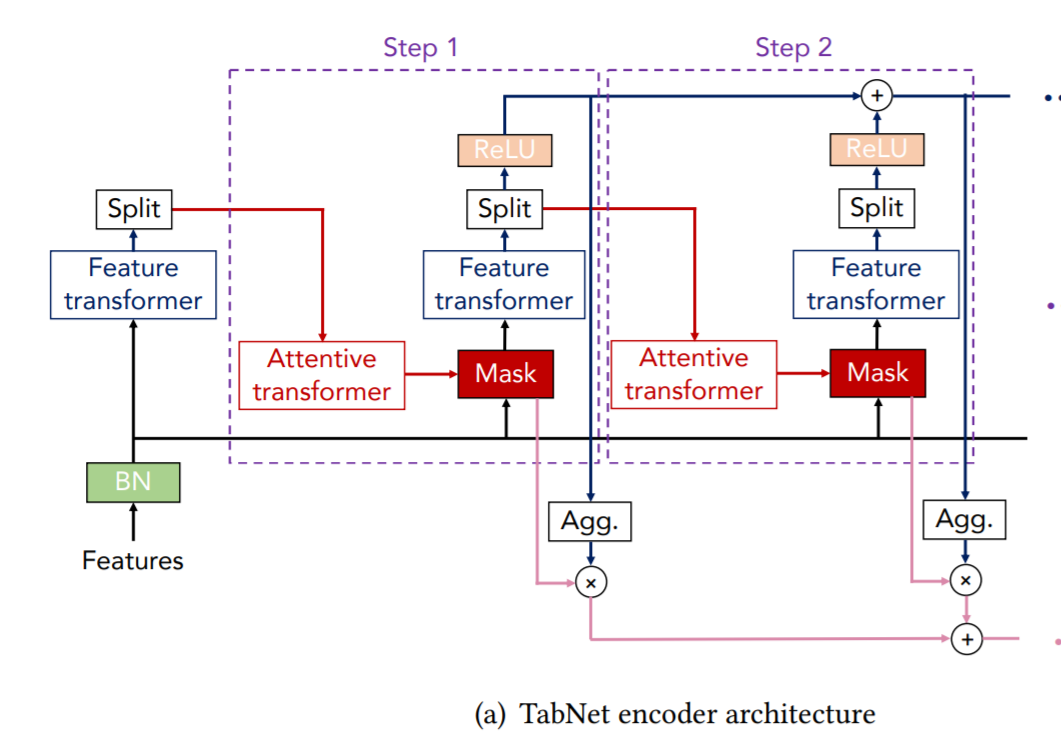
</div>
TabNet's encoder works by sequentially calculating masks (using an attention block) to be applied to the features. The masked features are then transformed at each step. Half of the transformed features will be used by the decoder, while the other half will be used by the next step's attention block.

The Encoder is built from 2 basic blocks: 

1. Feature Transformer - multiple stacks of blocks made up of FC, BN, GLUs with residual connections. The first few blocks are usually shared since the input's transformations should be the same across all steps. 
<div>
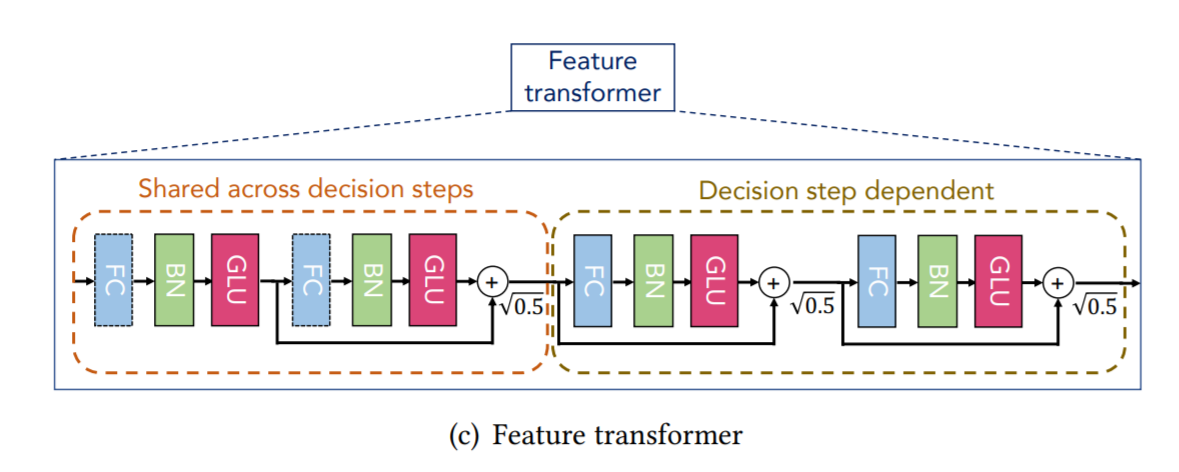
</div>

2. Attentive Transformer - creates the mask. A block consisting of a FC, BN and Sparsemax activation (with an additional prior to make sure that the same features won't be used too many times).
<div>
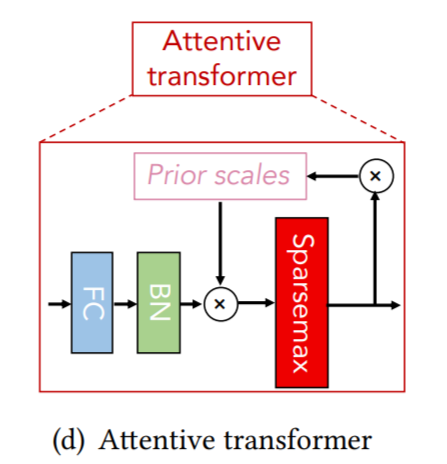
</div>

##### Head 

A simple layer that consists of adding up all the outputs from the encoder's steps and passing them through a FC layer. 

##### Self Supervised Training 

The self supervised training works by creating a mask `S` and applying it to keep some of the features, and then trying to reconstruct the `1-S` left over features. 
To implement the self supervised training, we need to replace the problem's loss (MSE, CE etc) with a loss that takes the forme into account as well as change the model's head to a decoder. 

1. Decoder - As seen above, we used the proposed architecture of a `Feature Transformer` for each step accompanied by a FC layer and then adding up all the results. 
<div>
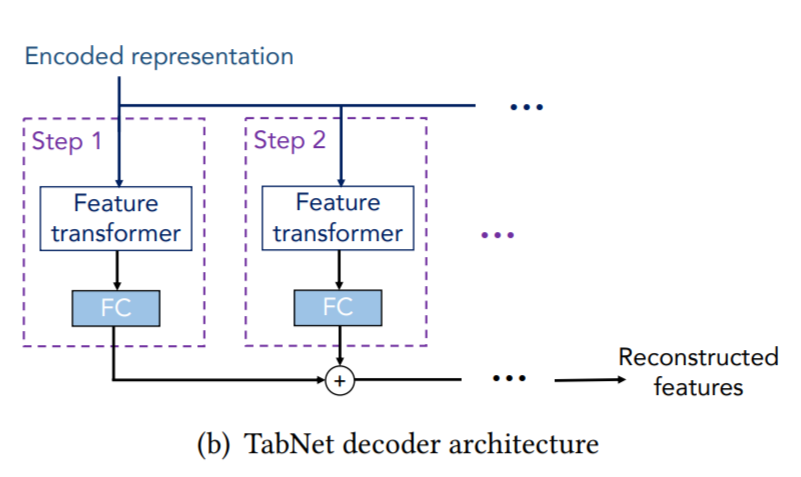
</div>

2. Loss - For the loss we used the proposed `Reconstruction Loss` which is similar to MSE/MAE for the reconstructed (non masked) features, as well as adding a regularization term (since they're scaled differently). 
    * B - batch size
    * D - # of features
    * S - The mask tensor 
<div>
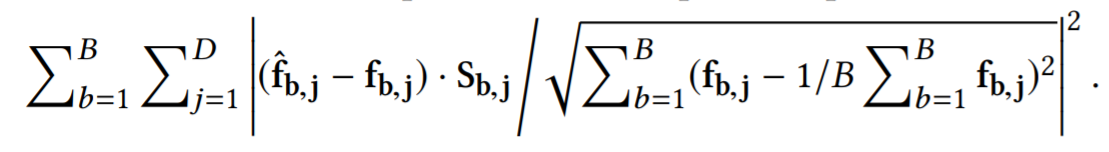
</div>

### Datasets

I've tested this approach on 2 different datasets: 
1. Adult Census Income - 32K rows where the task is to distinguish whether a person's income is above $50,000
1. Forest Cover - classifying the forst cover type from cartographic variables.

### Changes I made 

I've made the following changes and checked how they affect the result as explained in the next section.

#### Model Changes 

1. Replace the single FC `head` with multiple levels - A single FC seems too shallow. Maybe adding more will improve.

#### Self Supervised training 

I've implemented the self supervised training in 2 ways:
1. Create a random mask $S$ where the probability of each mask value is $p$. This creates a varying number of masked features at every iteration. 
1. Curricular learning - Progressively mask more features as the number of epochs grow. This is similar to a curricular becoming harder (need to reconstruct more values from less data). 

### My Approach

The changes I've made are as outlined in the previous section. 
In this section I'll specify the approach I took when experimenting and in the next section I'll show the results. 

> Each step that improved the scores was incorported into the model in the later steps. 

The steps: 
1. Create a baseline - Train the model on the datasets with the same parameters as in the paper to create baseline scores to compare to later (except the `#iterations`. Theirs totaled $~1k$ epochs takes way too long to train).
1. Test the effect of training the `head` on a small training set, with pretraining in a supervised manner on all the data.
1. Check if curricular learning somehow improves the previous results.


I've also experimented with a few other architectures for the decoder, classifier head. However, I didn't run exhaustive tests (for lack of time) so I'll just say that I didn't notice any noticeable results but I'll probably check this throughly later. 

# Experiments

### Baseline 

First I needed to create a baseline to compare results to. To create that baseline I implemented the TabNet model and ran it on the Adult, Forest Cover datasets multiple times with the parameters that were reported in the paper. The only difference I made was the number of epochs (I ran it for 350 VS 1K).
I also compared the scores with `fastai`'s built in `TabularModel` which has been used to win multiple kaggle competitions. 

#### Adult Dataset 

I trained the model 3 times, using an 80-20 split and the [1-cycle training policy](https://arxiv.org/abs/1708.07120) with a min LR of $5e^{-3}$, max LR of $1e{-2}$. 

I set the hyperparameters as repotred in the paper as following: $N_d=N_a=16$, $\lambda_{sparse}=1e{-4}$, $batch size=4096$, 
$virtual batch size=128$, $N_{steps}=5$, $\gamma=1.5$ with 2 shared blocks, 2 independent ones per `FeatureTransformer`. 

##### The results: 

The following graph depicts the scores with the stddev VS the size of the validation set. As we can see the score goes down the larger the validation set % (the smaller the training set). In the last experiment for example, we use a validation set of 99.5% which leaves 0.5% (~160 samples) for training. 

<div>
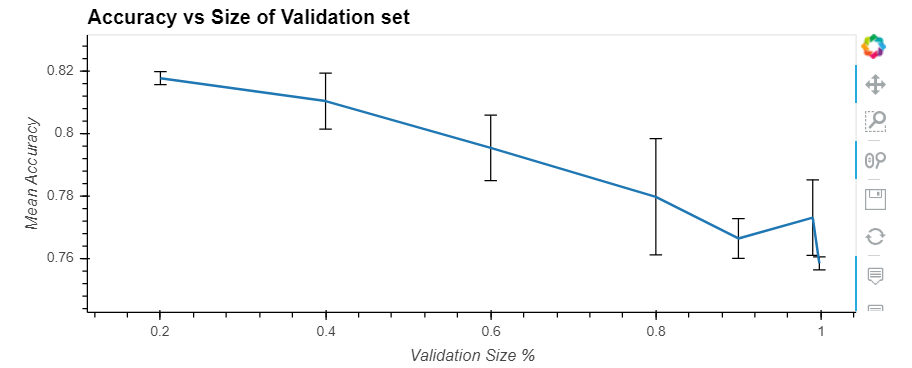
</div>

#### Forest Cover Dataset 

# Datasets

## Adult 

In [ ]:
path = untar_data(URLs.ADULT_SAMPLE)
df = pd.read_csv(path/'adult.csv')
params = dict(cat_names = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race'],
            cont_names = ['age', 'fnlwgt', 'education-num'], y_names='salary')
model_params = dict(n_d=16, n_a=16, lambda_sparse=1e-4, bs=1024*4, 
                          virtual_batch_size=128, n_steps=5, gamma=1.5)

## Forest Cover DS

In [4]:
data_dir = Path('./data')

In [5]:
def extract_gzip(file, dest=None):
    import gzip
    dest = dest or Path(dest)
    with gzip.open(file, 'rb') as f_in:
        with open(dest / file.stem, 'wb') as f_out:
            shutil.copyfileobj(f_in, f_out)

In [6]:
forest_type_url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/covtype/covtype.data.gz'
forest_path = untar_data(forest_type_url, dest=data_dir, extract_func=extract_gzip)

In [7]:
target = "Covertype"

cat_names = [
    "Wilderness_Area1", "Wilderness_Area2", "Wilderness_Area3",
    "Wilderness_Area4", "Soil_Type1", "Soil_Type2", "Soil_Type3", "Soil_Type4",
    "Soil_Type5", "Soil_Type6", "Soil_Type7", "Soil_Type8", "Soil_Type9",
    "Soil_Type10", "Soil_Type11", "Soil_Type12", "Soil_Type13", "Soil_Type14",
    "Soil_Type15", "Soil_Type16", "Soil_Type17", "Soil_Type18", "Soil_Type19",
    "Soil_Type20", "Soil_Type21", "Soil_Type22", "Soil_Type23", "Soil_Type24",
    "Soil_Type25", "Soil_Type26", "Soil_Type27", "Soil_Type28", "Soil_Type29",
    "Soil_Type30", "Soil_Type31", "Soil_Type32", "Soil_Type33", "Soil_Type34",
    "Soil_Type35", "Soil_Type36", "Soil_Type37", "Soil_Type38", "Soil_Type39",
    "Soil_Type40"
]

cont_names = [
    "Elevation", "Aspect", "Slope", "Horizontal_Distance_To_Hydrology",
    "Vertical_Distance_To_Hydrology", "Horizontal_Distance_To_Roadways",
    "Hillshade_9am", "Hillshade_Noon", "Hillshade_3pm",
    "Horizontal_Distance_To_Fire_Points"
]

feature_columns = (
    cont_names + cat_names + [target])

params = dict(cont_names = cont_names, y_names = target, cat_names = cat_names)
procs=[Categorify, FillMissing, Normalize]
model_params = dict(n_d=64, n_a=64, n_steps=5, virtual_batch_size=512, gamma=1.5, bs=1024*16,
                    lambda_sparse=1e-4, momentum=0.7, n_shared_ft_blocks=2, n_independent_ft_blocks=2)

In [8]:
df = pd.read_csv(forest_path, header=None, names=feature_columns).sample(n=200_000)
df.shape

(200000, 55)

# Baseline Scores 

In [13]:
n_epochs = 100

In [10]:
for val_pct in [0.998]*6:
    learn = tabnet_df_classifier(df, **params, val_pct=val_pct, **model_params)
    learn.dls.train.bs = learn.dls.train.n//2 if learn.dls.train.n < model_params['bs'] else model_params['bs']
    print(val_pct, learn.dls.train.n, learn.dls.valid.n)
    learn.fit_one_cycle(n_epochs, slice(5e-3, 1e-1))

0.998 400 199600


epoch,train_loss,valid_loss,accuracy,time
0,4.309308,3.936221,0.000276,00:01
1,3.973687,3.756775,0.365070,00:01
2,3.605116,3.012549,0.526743,00:01
3,3.238578,2.340282,0.566849,00:01
4,2.927382,2.021587,0.515736,00:01
5,2.641858,1.302918,0.571483,00:01
6,2.405426,1.246348,0.567144,00:01
7,2.242909,1.210205,0.558602,00:01
8,2.109362,1.122593,0.584830,00:01
9,1.990469,1.124984,0.540721,00:01


0.998 400 199600


epoch,train_loss,valid_loss,accuracy,time
0,4.142315,3.892243,0.000000,00:01
1,3.759556,3.682312,0.483763,00:01
2,3.406852,3.155286,0.487781,00:01
3,3.086296,2.371917,0.485401,00:01
4,2.799520,1.685031,0.496473,00:01
5,2.534763,1.350110,0.505341,00:01
6,2.318793,1.265700,0.479284,00:01
7,2.166767,1.291931,0.455466,00:01
8,2.046303,1.219401,0.494474,00:01
9,1.947117,1.223766,0.510025,00:01


0.998 400 199600


epoch,train_loss,valid_loss,accuracy,time
0,3.747233,3.884644,0.384494,00:01
1,3.469418,3.625099,0.488667,00:01
2,3.170686,3.180084,0.487936,00:01
3,2.854576,2.491952,0.488492,00:01
4,2.599335,1.602765,0.468507,00:01
5,2.368222,1.381947,0.424208,00:01
6,2.215901,1.291156,0.423257,00:01
7,2.090899,1.221927,0.471613,00:01
8,1.981645,1.250104,0.485215,00:01
9,1.890360,1.200323,0.581924,00:01


0.998 400 199600


epoch,train_loss,valid_loss,accuracy,time
0,3.907947,None,None,00:00


RuntimeError: CUDA error: device-side assert triggered

#### Adult Results 

In [ ]:
adult_res_values = {
            0.2:[0.82, 0.817, 0.816],
            0.4: [0.815, 0.80, 0.816],
            0.6: [0.806, 0.795, 0.785],
            0.8: [0.782, 0.76, 0.797],
            0.9: [0.77, 0.759, 0.77],
            0.99: [0.78, 0.759, 0.78],
            0.998: [0.756, 0.759, 0.760]
         }

adult_res = pd.DataFrame(adult_res_values)
adult_res = adult_res.melt(value_vars=adult_res_values.keys(), value_name='score', var_name='val_pct')

adult_res = adult_res.groupby('val_pct')['score'].agg({'mean', 'std'})
plt = (adult_res.hvplot.line(y='mean') * adult_res.hvplot.errorbars(y='mean', yerr1='std'))
plt.opts(xlabel='Validation Size %', ylabel='Mean Accuracy', title='Accuracy vs Size of Validation set')

#### Forest Results 

In [ ]:
forest_res_values = {
            0.2:[0.763, 0.757, 0.742],
            0.4: [0.742, 0.74, 0.753],
            0.6: [0.724, 0.715, 0.729],
            0.8: [0.526, 0.668, 0.675],
            0.9: [0.675, 0.671, 0.661],
            0.99: [0.668, 0.675, 0.681],
            0.998: [0.604, 0.64, 0.58]
         }

forest_res = pd.DataFrame(forest_res_values)
forest_res = forest_res.melt(value_vars=forest_res_values.keys(), value_name='score', var_name='val_pct')

forest_res = forest_res.groupby('val_pct')['score'].agg({'mean', 'std'})
plt = (forest_res.hvplot.line(y='mean') * forest_res.hvplot.errorbars(y='mean', yerr1='std'))
plt.opts(xlabel='Validation Size %', ylabel='Mean Accuracy', title='Accuracy vs Size of Validation set')

# Deep NN Head

In [ ]:
def deep_head(n_out, n_d, n_steps, layers=[100, 200], p=0.3, **kwargs):
    print(kwargs)
    szs = [n_d*n_steps, *layers, n_out]
    layers = [Lambda(lambda x: x.reshape(x.shape[0], -1))] + \
            [LinBnDrop(szs[i], szs[i+1], p=p, lin_first=True) for i in range(len(szs)-1)]
    return nn.Sequential(*layers)

In [ ]:
val_pct = 0.2
n_epochs = 30
head = linear_head

In [ ]:
learn = tabnet_df_classifier(df, **params, val_pct=val_pct, head=head, **model_params)
learn.dls.train.bs = learn.dls.train.n//2 if learn.dls.train.n < model_params['bs'] else model_params['bs']
print(val_pct, learn.dls.train.n, learn.dls.valid.n)
learn.fit_one_cycle(n_epochs, slice(5e-3, 1e-2))

# Self Supervision + Curriculum
In this experiment we'll train 2 models with self-supervised learning. One with curriculum learning and one without and check if it improves the score

In [ ]:
%%capture 
res = L([score_before_after_ss(df, params, model_params, cycle_lr=[(15, 1e-1/2)]*3) 
                             for i in range(5)])

In [ ]:
before = res.itemgot(0).map(lambda b: accuracy(*b))
after = res.itemgot(1).map(lambda b: accuracy(*b))

pd.DataFrame({'before': before, 'after': after}).agg(['mean', 'std'])

In [ ]:
%%capture 
res = L([score_before_after_ss(df, params, model_params, cycle_lr=[(15, 1e-1/2)]*3, curriculum=True) 
                             for i in range(2)])

In [ ]:
before = res.itemgot(0).map(lambda b: accuracy(*b))
after = res.itemgot(1).map(lambda b: accuracy(*b))

pd.DataFrame({'before': before, 'after': after}).agg(['mean', 'std'])

# Self Supervision For Small Label Regime 
In this experiment we'll check the affect of self supervised learning on problems without a lof of labels 

In [ ]:
@delegates()
class NanGrad(HookCallback):
    
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        
    def hook(self, m, i, o):
#         set_trace()
        for v in i:
            if v.isnan().any():
                set_trace()

In [ ]:
learn_ss = tabnet_df_self_sup(df, **params, **model_params, cbs=[], val_pct=0.2, loss_func=MSELossFlat())

In [ ]:
dl = learn_ss.dls.test_dl(df)

In [ ]:
preds, targs = learn_ss.get_preds(dl=dl)

In [ ]:
for p, t in zip(preds[0].tolist(), targs[0].tolist()):
    print('{:.3f}, {:.3f}'.format(p,t))

In [ ]:
learn_ss.dls.train.n, learn_ss.dls.valid.n
learn_ss.fit_one_cycle(30, slice(3e-3, 5e-1))

#### Forest Results

In [ ]:
forest_res_values = {
            0.2:[0.735],
            0.4: [0.734],
            0.6: [0.646],
            0.8: [0.644],
            0.9: [0.529],
            0.99: [0.484],
            0.998: [0.520]
         }

forest_res = pd.DataFrame(forest_res_values)
forest_res = forest_res.melt(value_vars=forest_res_values.keys(), value_name='score', var_name='val_pct')

forest_res = forest_res.groupby('val_pct')['score'].agg({'mean', 'std'})
plt = (forest_res.hvplot.line(y='mean') * forest_res.hvplot.errorbars(y='mean', yerr1='std'))
plt.opts(xlabel='Validation Size %', ylabel='Mean Accuracy', title='Accuracy vs Size of Validation set')